# Monte Carlo - Standoff Calculation

Author: Tobin Ford | tobin.ford@nrel.gov

2023
***
See Monte Carlo - Arrhenius Degredation for a more in depth guide. Steps will be shortened for brevity.

**Objectives**


In [ ]:
# if running on google colab, uncomment the next line and execute this cell to install the dependencies and prevent "ModuleNotFoundError" in later cells:
# !pip install pvdeg==0.2.0

In [192]:
import pvlib
import numpy as np
import pandas as pd
import pvdeg
import matplotlib.pyplot as plt

In [296]:
# This information helps with debugging and getting support :)
import sys, platform
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("Pvlib version ", pvlib.__version__)
print("Pvdeg version ", pvdeg.__version__)

Working on a  Windows 10
Python version  3.10.9 | packaged by Anaconda, Inc. | (main, Mar  8 2023, 10:42:25) [MSC v.1916 64 bit (AMD64)]
Pandas version  2.1.2
Pvlib version  0.10.2
Pvdeg version  0.2.0+38.g71cd910.dirty


### Simple Standoff Calculation

This is copied from another tutorial called `4 - Standards.ipynb`, please visit this page for a more in depth explanation of the process for a single standoff calculation.

In [187]:
weather_db = 'PSM3'
weather_id = (40.633365593159226, -73.9945801019899) # Manhattan, NYC
weather_arg = {'api_key': 'DEMO_KEY',
               'email': 'user@mail.com', # Get your own api key at https://developer.nrel.gov/signup/
               'names': 'tmy',
               'attributes': [],
               'map_variables': True}

WEATHER, META = pvdeg.weather.get(weather_db, weather_id, **weather_arg)

Column "relative_humidity" not found in DataFrame. Calculating...


In [188]:
sol_pos = pvdeg.spectral.solar_position(WEATHER, META)
poa_irradiance = pvdeg.spectral.poa_irradiance(WEATHER, META)
temp_mod = pvdeg.temperature.module(weather_df=WEATHER, meta=META, poa=poa_irradiance, conf='open_rack_glass_polymer')


In [189]:
# simple standoff calculation
height1 = pvdeg.standards.standoff(
    weather_df = WEATHER,
    meta = META
)

# more arguments standoff calculation
height2 = pvdeg.standards.standoff(weather_df=WEATHER, meta=META,
                                         level=2,
                                         tilt=None,
                                         azimuth=180,
                                         sky_model='isotropic',
                                         temp_model='sapm',
                                         module_type='glass_polymer',
                                         x_0=6.1,
                                         wind_speed_factor=1)

print(height1)
print(height2)

          x      T98_0    T98_inf
0  0.608698  72.506496  46.113842
          x      T98_0    T98_inf
0 -1.524517  72.506496  46.113842


In [228]:
"""Colection of functions for monte carlo simulations.
"""

# Challenges:
# how do we deal with different return types and inputs? Some functions return floats while others dataframes

### TODO:
# standards.standoff functionality
# corr list empty case


import numpy as np
import pandas as pd
from numba import njit
from scipy.linalg import cholesky
from scipy import stats
from typing import Callable
import inspect

# add list of all valid modeling constants? 
# this would restrict what users could do, pros vs cons

class Corr:     # could be made into a dataclass
    """corrlation class
    stores modeling constants and corresponding correlation coefficient to access at runtime
    """

    # modeling constants : str
    mc_1 = ''
    mc_2 = ''
    # corresonding corelation coefficient : float
    correlation = 0

    def __init__(self, mc_1_string, mc_2_string, corr): 
        """parameterized constructor"""
        self.mc_1 = mc_1_string
        self.mc_2 = mc_2_string
        self.correlation = corr
    
    def getModelingConstants(self)->list[str, str]:
        """
        Helper method. Returns modeling constants in string form.

        Parameters
        ----------
        self : Corr
            Reference to self

        Returns
        ----------
        modeling_constants : list[str, str]
            Both modeling constants in string from from their corresponding correlation coefficient object
        """

        modeling_constants = [self.mc_1, self.mc_2]
        return modeling_constants

def _symettric_correlation_matrix(corr: list[Corr])->pd.DataFrame:
    """
    Helper function. Generate a symmetric correlation coefficient matrix.

    Parameters
    ----------
    corr : list[Corr]
        All correlations between appropriate modeling constants

    Returns
    ----------
    identity_df : pd.DataFrame
        Matrix style DataFrame containing relationships between all input modeling constants
        Index and Column names represent modeling constants for comprehensibility
    """

    if not corr:
        return None

    # unpack individual modeling constants from correlations
    modeling_constants = [mc for i in corr for mc in i.getModelingConstants()]

    uniques = np.unique(modeling_constants)

    # setting up identity matrix, labels for columns and rows
    identity_matrix = np.eye(len(uniques)) 
    identity_df = pd.DataFrame(identity_matrix, columns = uniques, index=uniques)

    # walks matrix to fill in correlation coefficients
    # make this a modular standalone function if bigger function preformance is not improved with @njit 
    for i in range(len(uniques)):
        for j in range(i):  # only iterate over lower triangle
            x, y = identity_df.index[i], identity_df.columns[j]

            # find the correlation coefficient
            found = False
            for relation in corr:
                if set([x, y]) == set(relation.getModelingConstants()):
                    # fill in correlation coefficient
                    identity_df.iat[i, j] = relation.correlation
                    found = True
                    break

            # if no matches in all correlation coefficients, they will be uncorrelated (= 0)
            if not found:
                identity_df.iat[i, j] = 0  

    # mirror the matrix
    # this may be computationally expensive for large matricies
    # could be better to fill the original matrix in all in one go rather than doing lower triangular and mirroring it across I
    identity_df = identity_df + identity_df.T - np.diag(identity_df.to_numpy().diagonal())

    # identity_df should be renamed more appropriately 
    return identity_df

def _createStats(stats : dict[str, dict[str, float]], corr : list[Corr]) -> pd.DataFrame:
    """
    helper function. Unpacks mean and standard deviation for modeling constants into a DataFrame

    Parameters
    ----------
    stats : dict[str, dict[str, float]]
        contains mean and standard deviation for each modeling constant
        example of one mc:  {'Ea' : {'mean' : 62.08, 'stdev' : 7.3858 }}
    
    Returns
    ----------
    stats_df : pd.DataFrame
        contains unpacked means and standard deviations from dictionary
    """

    # empty correlation list case
    if not corr:
        stats_df = pd.DataFrame(stats)
        return stats_df


    # incomplete dataset
    for mc in stats:
        if 'mean' not in stats[mc] or 'stdev' not in stats[mc]:
            raise ValueError(f"Missing 'mean' or 'stdev' for modeling constant")

    # unpack data 
    modeling_constants = list(stats.keys())
    mc_mean = [stats[mc]['mean'] for mc in modeling_constants]
    mc_stdev = [stats[mc]['stdev'] for mc in modeling_constants]

    stats_df = pd.DataFrame({'mean' : mc_mean, 'stdev' : mc_stdev}, index=modeling_constants).T


    # flatten and reorder
    modeling_constants = [mc for i in corr for mc in i.getModelingConstants()]
    uniques = np.unique(modeling_constants)

    # what happens if columns do not match?  
    if len(uniques) != len(corr): 
        raise ValueError(f"correlation data is insufficient")
    
    # should match columns from correlation matrix
    stats_df = stats_df[uniques]

    return stats_df

def _correlateData(samples_to_correlate : pd.DataFrame, stats_for_correlation : pd.DataFrame) -> pd.DataFrame:

    """
    helper function. Uses meaningless correlated samples and makes meaningful by 
    multiplying random samples by their parent modeling constant's standard deviation
    and adding the mean

    Parameters
    ----------
    samples_to_correlate : pd.DataFrame
        contains n samples generated with N(0, 1) for each modeling constant
        column names must be consistent with all modeling constant inputs

    stats_for_correlation : pd.DataFrame
        contains mean and stdev each modeling constant,
        column names must be consistent with all modeling constant inputs

    Returns
    ----------
    correlated_samples : pd.DataFrame
        correlated samples in a tall dataframe. column names match modeling constant inputs,
        integer indexes. See generateCorrelatedSamples() references section for process info
    """

    # accounts for out of order column names, AS LONG AS ALL MATCH
    # UNKNOWN CASE: what will happen if there is an extra NON matching column in stats
    columns = list(samples_to_correlate.columns.values)
    ordered_stats = stats_for_correlation[columns]

    means = ordered_stats.loc['mean']
    stdevs = ordered_stats.loc['stdev']

    correlated_samples = samples_to_correlate.multiply(stdevs).add(means)

    return correlated_samples

def generateCorrelatedSamples(corr : list[Corr], stats : dict[str, dict[str, float]], n : int) -> pd.DataFrame:
    # columns are now named, may run into issues if more mean and stdev entries than correlation coefficients
    # havent tested yet but this could cause major issues (see lines 163 and 164 for info)

    """
    Generates a tall correlated samples numpy array based on correlation coefficients and mean and stdev 
    for modeling constants. Values are correlated from cholesky decomposition of correlation coefficients,
    and n random samples for each modeling constant generated from a standard distribution with mean = 0
    and standard deviation = 1.

    Parameters
    ----------
    corr : List[Corr]
        list containing correlations between variable

    stats : dict[str, dict[str, float]]
        dictionary storing variable mean and standard deviation. Syntax : `<variable_name> : {'mean' : <float>, 'stdev' : <float>}`

    n : int
        number of samples to create

    Returns
    ----------
    correlated_samples : pd.Dataframe
        tall dataframe of dimensions (n by # of modeling constants).
        Columns named as modeling constants from Corr object inputs

    References
    ----------
    Burgess, Nicholas, Correlated Monte Carlo Simulation using Cholesky Decomposition (March 25, 2022). 
    Available at SSRN: https://ssrn.com/abstract=4066115 
    """

    # coeff_matrix = _symettric_correlation_matrix(corr)

    # refactor?
    # feels messy 

    # base case
    if corr:
        coeff_matrix = _symettric_correlation_matrix(corr) # moved inside

        decomp = cholesky(coeff_matrix.to_numpy(), lower = True)

    samples = np.random.normal(loc=0, scale=1, size=(len(stats), n)) 
    
    stats_df = _createStats(stats, corr)    
    
    # no correlation data given, only stats
    if not corr:

        nocorr_df = pd.DataFrame(samples.T, columns=stats_df.columns.tolist())

        meaningful_nocorr_df = _correlateData(nocorr_df, stats_df)

        return meaningful_nocorr_df

    if corr:
        precorrelated_samples = np.matmul(decomp, samples) 

        precorrelated_df = pd.DataFrame(precorrelated_samples.T, columns=coeff_matrix.columns.to_list())

        correlated_df = _correlateData(precorrelated_df, stats_df)

        return correlated_df

# HAD TO MAKE lnr0 lowercase, all parameters must be lowercase for now 
@njit
def vecArrhenius(
    poa_global : np.ndarray, 
    module_temp : np.ndarray, 
    ea : float, 
    x : float, 
    lnr0 : float
    ) -> float: 

    """
    Calculates degradation using :math:`R_D = R_0 * I^X * e^{\\frac{-Ea}{kT}}`

    Parameters
    ----------
    poa_global : numpy.ndarray
        Plane of array irradiance [W/m^2]

    module_temp : numpy.ndarray
        Cell temperature [C].

    ea : float
        Activation energy [kJ/mol]

    x : float
        Irradiance relation [unitless]

    lnR0 : float
        prefactor [ln(%/h)]

    Returns
    ----------
    degredation : float
        Degradation Rate [%/h]  

    """

    mask = poa_global >= 25
    poa_global = poa_global[mask]
    module_temp = module_temp[mask]

    ea_scaled = ea / 8.31446261815324E-03
    R0 = np.exp(lnr0)
    poa_global_scaled = poa_global / 1000

    degredation = 0
    # refactor to list comprehension approach
    for entry in range(len(poa_global_scaled)):
        degredation += R0 * np.exp(-ea_scaled / (273.15 + module_temp[entry])) * np.power(poa_global_scaled[entry], x)

    return (degredation / len(poa_global))

# monte carlo function
# model after - https://github.com/NREL/PVDegradationTools/blob/main/pvdeg_tutorials/tutorials/LETID%20-%20Outdoor%20Geospatial%20Demo.ipynb

def simulate(
    func : Callable,
    correlated_samples : pd.DataFrame, 
    **function_kwargs
    ):

    """
    Applies a target function to data to preform a monte carlo simulation

    Parameters
    ----------
    func : function
        Function to apply for monte carlo simulation
    correlated_samples : pd.DataFrame        
        Dataframe of correlated samples with named columns for each appropriate modeling constant, can be generated using generateCorrelatedSamples()
    func_kwargs : dict
        Keyword arguments to pass to func, only include arguments not named in your correlated_samples columns

    Returns
    -------
    res : pandas.DataFrame
        DataFrame with monte carlo results from target function
    """

    ### NOTES ###   
    # func modeling constant parameters must be lowercase in function definition
    # dynamically construct argument list for func
    # call func with .apply(lambda)

    args = {k.lower(): v for k, v in function_kwargs.items()} # make lowercase

    func_signature = inspect.signature(func)
    # print(f"func_signature: {func_signature}")
    func_args = set(func_signature.parameters.keys())
    # print(f"func_args: {func_args}")

    def prepare_args(row):
        return {arg: row[arg] if arg in row else function_kwargs.get(arg) for arg in func_args}

    args = prepare_args(correlated_samples.iloc[0])
    # print(f"args: {args}")

    def apply_func(row):
        row_args = {**args, **{k.lower(): v for k, v in row.items()}}
        # print(f"Row args: {row_args}")
        return func(**row_args)

    # this line is often flagged when target function is not given required arguments
    result = correlated_samples.apply(apply_func, axis=1)

    return result

### Defining Correlation Coefficients and mean and standard deviation

We will leave the list of correlations blank because our variables are not correlated. For a correlated use case visit the `Monte Carlo - Arrhenius.ipynb` tutorial.

Mean and standard deviation must always be populated if being used to create a dataset. However, you can feed your own correlated or uncorrelated data into the simulate function but column names must be consistent.

In [297]:
# These numbers do not make sense in the context of the problem but work for demonstraiting the process
stats = {
    'X_0' : {'mean' : 5, 'stdev' : 3},
    'wind_speed_factor' : {'mean' : 0.5, 'stdev' : 0.2} 
}

### TWO CASES (no correlation) ###
# user enters 0 value ✖
# user does leaves blank ✓

# corr_coeff = [pvdeg.montecarlo.Corr('X_0', 'wind_speed_factor', 0)]
corr_coeff = []

# works when I copy the pvdeg code into the notebook but not otherwise
samples = generateCorrelatedSamples(corr_coeff, stats, 500)
# samples = pvdeg.montecarlo.generateCorrelatedSamples(corr_coeff, stats, 10)

In [298]:
print(samples)

           X_0  wind_speed_factor
0    10.933864           0.908651
1     8.560611           0.642289
2     3.297961           0.497892
3     1.888439           0.729959
4     5.279248           0.796141
..         ...                ...
495   6.442757           0.314854
496   5.747671           0.616316
497   3.093798           0.119871
498   5.234074           0.554964
499   4.671608           0.206893

[500 rows x 2 columns]


#### Standoff Monte Carlo Inputs

When using the pvdeg.montecarlo.simulate() function on a target function all of the target function's required arguments must still be given. Our non-changing arguments will be stored in a dictionary. The randomized monte carlo input data will also be passed to the target function via the simulate function. All required target function arguments should be contained between the column names of the randomized input data and fixed argument dictionary, 

In [299]:
# defining arguments to pass to the target function, standoff() in this case
function_kwargs = {
    'weather_df' : WEATHER,
    'meta' : META,
    'level' : 2,
    'tilt' : None,
    'azimuth' : 180,
    'sky_model' : 'isotropic',
    'temp_model' : 'sapm',
    'module_type' : 'glass_polymer'
} 
# notice how we left off parts we want to use in the monte carlo simulation because they are already contained in the dataframe

results = pvdeg.montecarlo.simulate(pvdeg.standards.standoff, samples, **function_kwargs)

#### Dealing With Series 
Notice how our results are contained in a pandas series instead of a dataframe. 

This means we have to do an extra step to view our results. Run the block below to confirm that our results are indeed contained in a series. And convert them into a simpler dataframe.

In [300]:
print(type(results))

results_df = pd.concat(results.tolist()).reset_index(drop=True)

<class 'pandas.core.series.Series'>


In [301]:
print(results_df)

            x      T98_0    T98_inf
0   -2.536189  73.054759  46.451343
1   -1.567804  74.554740  47.461807
2   -0.495222  75.552767  48.104118
3   -0.380235  73.985983  47.023509
4   -1.120263  73.650281  46.789835
..        ...        ...        ...
495 -0.705024  76.780373  48.938743
496 -1.002845  74.810109  47.584479
497 -0.197972  78.139486  49.984720
498 -0.830120  75.284313  47.846500
499 -0.394913  77.530284  49.532328

[500 rows x 3 columns]


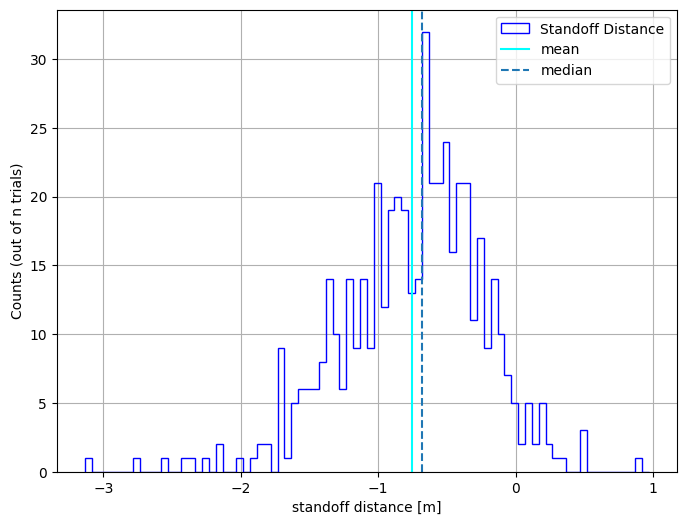

In [311]:
bin_edges = np.arange(results_df['x'].min(), results_df['x'].max() + 0.1, 0.05)
plt.figure(figsize=(8,6))
plt.hist(results_df['x'], bins=bin_edges, edgecolor='blue', histtype='step', linewidth=1, label = 'Standoff Distance')
plt.ylabel('Counts (out of n trials)')
plt.xlabel('standoff distance [m]')
plt.axvline(np.mean(results_df['x']), color = 'cyan', label = 'mean' )
plt.axvline(np.median(results_df['x']), linestyle='--', label = 'median')

plt.legend()
plt.grid(True)
plt.show()